In [1]:
# install for AWS
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision
!pip install s3fs
!pip install boto3
!pip install tqdm
# !pip install fiftyone

DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standa

In [2]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from io import BytesIO
from torch import nn, optim
from tqdm import tqdm

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# import fiftyone as fo
# import fiftyone.brain as fob
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F

# Define Hyperparams

In [3]:
batch_size = 32
learning_rate = 0.001
fine_tune_learning_rate = learning_rate / 10
num_classes = 52
num_epochs = 3
fine_tune_epochs = 3
disparity_weight = 0.1
alpha = 0.5
temperature = 5.0

# Load, Transform, and Split Data

In [4]:
# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

In [5]:
# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [6]:
# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}annotations.csv'
df = pd.read_csv(annotations_s3_path)

In [7]:
# Extracting unique class labels from the 'class1' column
classes = df['class1'].unique()

# Creating a mapping from index to class label
idx_to_class = {i: j for i, j in enumerate(classes)}

# Creating a reverse mapping from class label to index
class_to_idx = {value: key for key, value in idx_to_class.items()}

# Creating a mapping from index to annotation column name starting from the 7th column
idx_to_annot = {i: j for i, j in enumerate(df.columns[6:])}


In [8]:
# check count of jpg files
def count_jpg_files(bucket_name, prefix=''):
    """
    Count the number of .jpg files in an S3 bucket under a given prefix.
    
    Parameters:
    - bucket_name (str): Name of the S3 bucket.
    - prefix (str): Prefix path to filter results. Default is empty.
    
    Returns:
    - count (int): Count of .jpg files.
    """
    count = 0
    paginator = s3_client.get_paginator('list_objects_v2')
    
    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'].endswith('.jpg'):
                count += 1

    return count

# Count .jpg files in the 'w210facetdata' bucket under the 'images/' prefix
jpg_count = count_jpg_files(bucket_name, images_prefix)
print(f"Number of .jpg files in the '{bucket_name}/{images_prefix}' path: {jpg_count}")


Number of .jpg files in the 'w210facetdata/images/' path: 31702


In [9]:
df.iloc[0][6:]

gender_presentation_masc          0
gender_presentation_fem           1
gender_presentation_non_binary    0
gender_presentation_na            0
skin_tone_1                       2
skin_tone_2                       3
skin_tone_3                       0
skin_tone_4                       0
skin_tone_5                       0
skin_tone_6                       0
skin_tone_7                       0
skin_tone_8                       0
skin_tone_9                       0
skin_tone_10                      0
skin_tone_na                      0
age_presentation_young            0
age_presentation_older            0
age_presentation_middle           1
age_presentation_na               0
hair_color_brown                  0
hair_color_blonde                 1
hair_color_grey                   0
hair_color_na                     0
hair_color_black                  0
hair_color_colored                0
hair_color_red                    0
hairtype_coily                    0
hairtype_dreadlocks         

In [10]:
idx_to_class

{0: 'gymnast',
 1: 'boatman',
 2: 'lifeguard',
 3: 'backpacker',
 4: 'lawman',
 5: 'dancer',
 6: 'laborer',
 7: 'patient',
 8: 'basketball_player',
 9: 'nurse',
 10: 'singer',
 11: 'motorcyclist',
 12: 'astronaut',
 13: 'fireman',
 14: 'referee',
 15: 'speaker',
 16: 'guitarist',
 17: 'repairman',
 18: 'craftsman',
 19: 'guard',
 20: 'painter',
 21: 'doctor',
 22: 'farmer',
 23: 'drummer',
 24: 'climber',
 25: 'disk_jockey',
 26: 'soccer_player',
 27: 'student',
 28: 'soldier',
 29: 'cheerleader',
 30: 'flutist',
 31: 'runner',
 32: 'retailer',
 33: 'machinist',
 34: 'reporter',
 35: 'horseman',
 36: 'tennis_player',
 37: 'computer_user',
 38: 'carpenter',
 39: 'seller',
 40: 'skateboarder',
 41: 'gardener',
 42: 'waiter',
 43: 'prayer',
 44: 'ballplayer',
 45: 'sculptor',
 46: 'teacher',
 47: 'electrician',
 48: 'hairdresser',
 49: 'judge',
 50: 'trumpeter',
 51: 'bartender'}

In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [13]:
# toggle on/off subsetting
# Define the number of samples you want in your subset
subset_size = 1000  # Adjust the size as needed

# Create a smaller subset of your dataset
train_data = train_data[:subset_size]
test_data = test_data[:subset_size]
val_data = val_data[:subset_size]

In [14]:
# Define additional metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Lists to store metric values during training
train_losses_student, val_losses_student, train_losses_teacher, val_losses_teacher = [], [], [], []
train_accuracies_student, val_accuracies_student, train_accuracies_teacher, val_accuracies_teacher = [], [], [], []


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 2]
        image_key = f'{images_prefix}{img_name}'  # Construct S3 object key
        # Load image from S3
        img_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        img_data = img_object['Body'].read()
        # Open the image directly from the byte stream using PIL
        image = Image.open(BytesIO(img_data))
        annotations = self.data.iloc[idx, 6:].values.astype(np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = 'FACET'  # Local directory if you want to save images locally
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


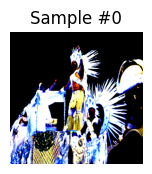

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


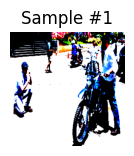

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


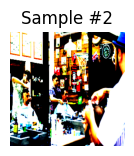

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


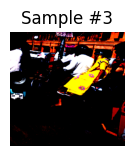

In [17]:
fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(np.transpose(sample[0], [1,2,0]))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break


# Model

In [18]:
# device = torch.device('mps')

# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
# class DeepNN(nn.Module):
#     def __init__(self, num_classes=52):
#         super(DeepNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(131072, 512),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = torchvision.models.resnet50(pretrained=True)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, num_classes)
teacher_model = teacher_model.to(device)

student_model = LightNN(num_classes=num_classes).to(device)

# Load pre-trained weights if available
pretrained_path = 'pretrained_student.pth'
if os.path.exists(pretrained_path):
    student_model.load_state_dict(torch.load(pretrained_path))
    print("Loaded pre-trained weights for student model.")

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)


# Train


In [19]:
# Define attributes and concepts in your dataset
attributes = df.columns[6:].tolist()  # All attributes
concepts = list(idx_to_class.values())  # All concepts

# Create a dictionary to map attribute names to column indices
attr_idx = {attr: idx for idx, attr in enumerate(attributes)}

# Initialize dictionaries to store recall values for teacher and student models
teacher_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
student_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}


Epoch 1/6:   3%|██▎                                                                       | 1/32 [00:11<05:53, 11.42s/it]

KD Loss: 3.989830656792037e-05
CE Loss: 3.9479024410247803
Disparity Loss: -0.787501871585846
Total Loss: 1.186469316482544
teacher_recall: 0.03125, student_recall: 0.0625


Epoch 1/6:   6%|████▋                                                                     | 2/32 [00:23<05:54, 11.82s/it]

KD Loss: 0.003081283299252391
CE Loss: 6.002679824829102
Disparity Loss: -0.6687507033348083
Total Loss: 2.334129810333252
teacher_recall: 0.03125, student_recall: 0.0625


Epoch 1/6:   9%|██████▉                                                                   | 3/32 [00:35<05:41, 11.76s/it]

KD Loss: 0.0025502743665128946
CE Loss: 7.326373100280762
Disparity Loss: -0.054687488824129105
Total Loss: 3.609774112701416
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  12%|█████████▎                                                                | 4/32 [00:46<05:29, 11.76s/it]

KD Loss: 0.0013214221689850092
CE Loss: 5.507564067840576
Disparity Loss: -0.6312509179115295
Total Loss: 2.1231918334960938
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  16%|███████████▌                                                              | 5/32 [00:58<05:14, 11.66s/it]

KD Loss: 0.000960766279604286
CE Loss: 4.291683197021484
Disparity Loss: -0.1473957896232605
Total Loss: 1.9989261627197266
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  19%|█████████████▉                                                            | 6/32 [01:10<05:03, 11.68s/it]

KD Loss: 0.0008020213572308421
CE Loss: 3.975637674331665
Disparity Loss: 1.2173947095870972
Total Loss: 3.2056145668029785
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  22%|████████████████▏                                                         | 7/32 [01:22<04:54, 11.77s/it]

KD Loss: 0.0003799235273618251
CE Loss: 4.292506217956543
Disparity Loss: 1.1027971506118774
Total Loss: 3.2492403984069824
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  25%|██████████████████▌                                                       | 8/32 [01:33<04:40, 11.69s/it]

KD Loss: 0.0002873672638088465
CE Loss: 4.470844745635986
Disparity Loss: 1.4418078660964966
Total Loss: 3.6773738861083984
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  28%|████████████████████▊                                                     | 9/32 [01:44<04:26, 11.58s/it]

KD Loss: 0.0001862593344412744
CE Loss: 4.370635509490967
Disparity Loss: 1.0464807748794556
Total Loss: 3.231891632080078
teacher_recall: 0.03125, student_recall: 0.0


Epoch 1/6:  31%|██████████████████████▊                                                  | 10/32 [01:56<04:11, 11.42s/it]

KD Loss: 0.0002081925777019933
CE Loss: 3.906038999557495
Disparity Loss: 1.0161690711975098
Total Loss: 2.969292640686035
teacher_recall: 0.0625, student_recall: 0.0625


Epoch 1/6:  34%|█████████████████████████                                                | 11/32 [02:07<03:58, 11.38s/it]

KD Loss: 0.00017748866230249405
CE Loss: 4.101935863494873
Disparity Loss: 0.9977095723152161
Total Loss: 3.0487661361694336
teacher_recall: 0.0625, student_recall: 0.0625


Epoch 1/6:  38%|███████████████████████████▍                                             | 12/32 [02:18<03:46, 11.34s/it]

KD Loss: 0.0001279103016713634
CE Loss: 3.956514835357666
Disparity Loss: 0.9215680956840515
Total Loss: 2.8998894691467285
teacher_recall: 0.0625, student_recall: 0.0625


Epoch 1/6:  41%|█████████████████████████████▋                                           | 13/32 [02:30<03:37, 11.46s/it]

KD Loss: 0.00013190934259910136
CE Loss: 3.9754045009613037
Disparity Loss: 0.6070955991744995
Total Loss: 2.5948638916015625
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  44%|███████████████████████████████▉                                         | 14/32 [02:41<03:23, 11.33s/it]

KD Loss: 0.00010614613711368293
CE Loss: 3.9120142459869385
Disparity Loss: 0.36014193296432495
Total Loss: 2.316202163696289
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  47%|██████████████████████████████████▏                                      | 15/32 [02:52<03:10, 11.19s/it]

KD Loss: 8.159034041455016e-05
CE Loss: 3.89042067527771
Disparity Loss: 0.5925646424293518
Total Loss: 2.537815809249878
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  50%|████████████████████████████████████▌                                    | 16/32 [03:03<03:00, 11.27s/it]

KD Loss: 9.33299379539676e-05
CE Loss: 3.8764901161193848
Disparity Loss: -0.04903656616806984
Total Loss: 1.8892550468444824
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  53%|██████████████████████████████████████▊                                  | 17/32 [03:15<02:49, 11.31s/it]

KD Loss: 9.949901141226292e-05
CE Loss: 3.8534207344055176
Disparity Loss: -0.7336133122444153
Total Loss: 1.1931467056274414
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  56%|█████████████████████████████████████████                                | 18/32 [03:25<02:36, 11.20s/it]

KD Loss: 8.128292392939329e-05
CE Loss: 3.913051128387451
Disparity Loss: -0.7051180601119995
Total Loss: 1.251448154449463
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  59%|███████████████████████████████████████████▎                             | 19/32 [03:37<02:28, 11.43s/it]

KD Loss: 6.679966463707387e-05
CE Loss: 3.9318625926971436
Disparity Loss: -0.4982021152973175
Total Loss: 1.4677625894546509
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [03:48<02:15, 11.30s/it]

KD Loss: 0.00010154569463338703
CE Loss: 3.9013619422912598
Disparity Loss: -0.6584872603416443
Total Loss: 1.2922444343566895
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [03:59<02:02, 11.14s/it]

KD Loss: 9.239435166819021e-05
CE Loss: 3.9205949306488037
Disparity Loss: -0.6261266469955444
Total Loss: 1.3342170715332031
teacher_recall: 0.0, student_recall: 0.03125


Epoch 1/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [04:10<01:50, 11.06s/it]

KD Loss: 7.596659997943789e-05
CE Loss: 3.9393327236175537
Disparity Loss: -0.3950187563896179
Total Loss: 1.5746855735778809
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [04:21<01:40, 11.11s/it]

KD Loss: 7.930471474537626e-05
CE Loss: 3.917100667953491
Disparity Loss: -0.15110018849372864
Total Loss: 1.8074898719787598
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [04:33<01:29, 11.19s/it]

KD Loss: 9.352833876619115e-05
CE Loss: 3.885802984237671
Disparity Loss: -0.5330170392990112
Total Loss: 1.4099311828613281
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [04:44<01:19, 11.33s/it]

KD Loss: 6.967861554585397e-05
CE Loss: 3.878676176071167
Disparity Loss: -0.9405968189239502
Total Loss: 0.9987760782241821
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [04:55<01:06, 11.15s/it]

KD Loss: 6.783595017623156e-05
CE Loss: 3.786202907562256
Disparity Loss: -0.9085472226142883
Total Loss: 0.9845882058143616
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [05:06<00:55, 11.05s/it]

KD Loss: 6.230591679923236e-05
CE Loss: 3.7961223125457764
Disparity Loss: -1.196533441543579
Total Loss: 0.7015588283538818
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [05:17<00:44, 11.04s/it]

KD Loss: 0.000165302146342583
CE Loss: 3.999305009841919
Disparity Loss: -1.3632676601409912
Total Loss: 0.636467456817627
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [05:27<00:32, 10.89s/it]

KD Loss: 0.00011269807873759419
CE Loss: 3.8750553131103516
Disparity Loss: -1.4651782512664795
Total Loss: 0.4724057912826538
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [05:38<00:21, 10.84s/it]

KD Loss: 0.00016674137441441417
CE Loss: 3.691868305206299
Disparity Loss: -1.3038465976715088
Total Loss: 0.5421708822250366
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [05:49<00:10, 10.73s/it]

KD Loss: 8.072967466432601e-05
CE Loss: 3.702427625656128
Disparity Loss: -1.4116315841674805
Total Loss: 0.4396226406097412
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 1/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [05:51<00:00, 10.99s/it]


KD Loss: 0.00011042007827199996
CE Loss: 3.673098564147949
Disparity Loss: -1.6416985988616943
Total Loss: 0.19490587711334229
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:   3%|██▎                                                                       | 1/32 [00:10<05:38, 10.91s/it]

KD Loss: 9.735902131069452e-05
CE Loss: 3.7532336711883545
Disparity Loss: -1.9515820741653442
Total Loss: -0.07491660118103027
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:   6%|████▋                                                                     | 2/32 [00:22<05:33, 11.11s/it]

KD Loss: 0.00012801085540559143
CE Loss: 3.6728553771972656
Disparity Loss: -2.1411588191986084
Total Loss: -0.3046671152114868
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:   9%|██████▉                                                                   | 3/32 [00:33<05:23, 11.17s/it]

KD Loss: 7.188680319814011e-05
CE Loss: 3.551321268081665
Disparity Loss: -2.603726625442505
Total Loss: -0.828029990196228
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:  12%|█████████▎                                                                | 4/32 [00:44<05:12, 11.17s/it]

KD Loss: 0.0002804869436658919
CE Loss: 3.592160701751709
Disparity Loss: -2.887774705886841
Total Loss: -1.0915541648864746
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:  16%|███████████▌                                                              | 5/32 [00:55<04:58, 11.05s/it]

KD Loss: 0.00018347070727031678
CE Loss: 3.617670774459839
Disparity Loss: -3.0658133029937744
Total Loss: -1.2568861246109009
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:  19%|█████████████▉                                                            | 6/32 [01:06<04:44, 10.93s/it]

KD Loss: 0.00016827130457386374
CE Loss: 3.703373908996582
Disparity Loss: -3.124969244003296
Total Loss: -1.273198127746582
teacher_recall: 0.0625, student_recall: 0.03125


Epoch 2/6:  22%|████████████████▏                                                         | 7/32 [01:16<04:30, 10.83s/it]

KD Loss: 0.00037781521677970886
CE Loss: 3.8123879432678223
Disparity Loss: -3.692214250564575
Total Loss: -1.785831332206726
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  25%|██████████████████▌                                                       | 8/32 [01:27<04:19, 10.81s/it]

KD Loss: 0.00014791791909374297
CE Loss: 3.5712363719940186
Disparity Loss: -4.131977081298828
Total Loss: -2.346284866333008
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  28%|████████████████████▊                                                     | 9/32 [01:37<04:05, 10.69s/it]

KD Loss: 0.0003555569564923644
CE Loss: 3.54073166847229
Disparity Loss: -4.152733325958252
Total Loss: -2.3821897506713867
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  31%|██████████████████████▊                                                  | 10/32 [01:48<03:54, 10.66s/it]

KD Loss: 0.00043829710921272635
CE Loss: 3.4677186012268066
Disparity Loss: -4.073384761810303
Total Loss: -2.339306354522705
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  34%|█████████████████████████                                                | 11/32 [01:59<03:48, 10.87s/it]

KD Loss: 0.00041582496487535536
CE Loss: 3.7501380443573
Disparity Loss: -4.114233493804932
Total Loss: -2.2389564514160156
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  38%|███████████████████████████▍                                             | 12/32 [02:10<03:36, 10.84s/it]

KD Loss: 0.00032680280855856836
CE Loss: 3.3425841331481934
Disparity Loss: -4.056522846221924
Total Loss: -2.3850674629211426
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  41%|█████████████████████████████▋                                           | 13/32 [02:21<03:25, 10.84s/it]

KD Loss: 0.0003060037852264941
CE Loss: 3.6415388584136963
Disparity Loss: -4.282609939575195
Total Loss: -2.4616875648498535
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  44%|███████████████████████████████▉                                         | 14/32 [02:32<03:17, 10.95s/it]

KD Loss: 0.0004198997630737722
CE Loss: 3.3992230892181396
Disparity Loss: -4.480165004730225
Total Loss: -2.780343532562256
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  47%|██████████████████████████████████▏                                      | 15/32 [02:43<03:05, 10.90s/it]

KD Loss: 0.0002894328790716827
CE Loss: 3.4570186138153076
Disparity Loss: -4.9536542892456055
Total Loss: -3.2250003814697266
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  50%|████████████████████████████████████▌                                    | 16/32 [02:54<02:53, 10.82s/it]

KD Loss: 0.00028871119138784707
CE Loss: 3.5805513858795166
Disparity Loss: -5.156337261199951
Total Loss: -3.365917205810547
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  53%|██████████████████████████████████████▊                                  | 17/32 [03:04<02:41, 10.77s/it]

KD Loss: 0.00023390119895339012
CE Loss: 3.433734178543091
Disparity Loss: -5.527415752410889
Total Loss: -3.810431718826294
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  56%|█████████████████████████████████████████                                | 18/32 [03:15<02:30, 10.72s/it]

KD Loss: 0.0003157223982270807
CE Loss: 3.7772653102874756
Disparity Loss: -5.967884063720703
Total Loss: -4.0790934562683105
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  59%|███████████████████████████████████████████▎                             | 19/32 [03:25<02:18, 10.63s/it]

KD Loss: 0.00016860384494066238
CE Loss: 3.67802357673645
Disparity Loss: -6.262292861938477
Total Loss: -4.423196792602539
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [03:37<02:10, 10.89s/it]

KD Loss: 0.0002072133938781917
CE Loss: 3.3753414154052734
Disparity Loss: -6.582875728607178
Total Loss: -4.895101547241211
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [03:47<01:58, 10.82s/it]

KD Loss: 0.00028450728859752417
CE Loss: 3.3411078453063965
Disparity Loss: -6.859881401062012
Total Loss: -5.18918514251709
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [03:58<01:48, 10.85s/it]

KD Loss: 0.00024078198475763202
CE Loss: 3.551180124282837
Disparity Loss: -7.13731575012207
Total Loss: -5.361605167388916
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [04:09<01:36, 10.74s/it]

KD Loss: 0.00025690800976008177
CE Loss: 3.4574954509735107
Disparity Loss: -7.565262794494629
Total Loss: -5.836386680603027
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [04:19<01:25, 10.69s/it]

KD Loss: 0.00022776477271690965
CE Loss: 3.1895275115966797
Disparity Loss: -7.730555057525635
Total Loss: -6.135677337646484
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [04:30<01:15, 10.76s/it]

KD Loss: 0.00017836883489508182
CE Loss: 3.44970440864563
Disparity Loss: -8.161928176879883
Total Loss: -6.436986923217773
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [04:41<01:05, 10.85s/it]

KD Loss: 0.0003634608874563128
CE Loss: 3.525465488433838
Disparity Loss: -8.312572479248047
Total Loss: -6.549657821655273
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [04:52<00:54, 10.81s/it]

KD Loss: 0.00023163027071859688
CE Loss: 3.457529067993164
Disparity Loss: -8.465682983398438
Total Loss: -6.736802577972412
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [05:03<00:43, 10.75s/it]

KD Loss: 0.00023258515284396708
CE Loss: 3.4082181453704834
Disparity Loss: -8.532447814941406
Total Loss: -6.828222274780273
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [05:14<00:32, 10.96s/it]

KD Loss: 0.00020941774710081518
CE Loss: 3.4066903591156006
Disparity Loss: -8.75275707244873
Total Loss: -7.049307346343994
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [05:25<00:21, 10.93s/it]

KD Loss: 0.00019937919569201767
CE Loss: 3.5228569507598877
Disparity Loss: -8.791203498840332
Total Loss: -7.029675483703613
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [05:36<00:10, 10.86s/it]

KD Loss: 0.0001991770404856652
CE Loss: 3.4296765327453613
Disparity Loss: -8.961015701293945
Total Loss: -7.246078014373779
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 2/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [05:38<00:00, 10.59s/it]


KD Loss: 0.00030913081718608737
CE Loss: 3.3903071880340576
Disparity Loss: -8.925868034362793
Total Loss: -7.230559825897217
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:   3%|██▎                                                                       | 1/32 [00:10<05:26, 10.55s/it]

KD Loss: 0.00040615006582811475
CE Loss: 2.931457042694092
Disparity Loss: -9.242016792297363
Total Loss: -7.776084899902344
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:   6%|████▋                                                                     | 2/32 [00:20<05:09, 10.33s/it]

KD Loss: 0.000482395407743752
CE Loss: 2.99513578414917
Disparity Loss: -9.449660301208496
Total Loss: -7.9518513679504395
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:   9%|██████▉                                                                   | 3/32 [00:31<05:00, 10.36s/it]

KD Loss: 0.00032811134587973356
CE Loss: 3.313261032104492
Disparity Loss: -9.589888572692871
Total Loss: -7.933094024658203
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  12%|█████████▎                                                                | 4/32 [00:41<04:48, 10.31s/it]

KD Loss: 0.0005333093577064574
CE Loss: 3.0492727756500244
Disparity Loss: -9.724811553955078
Total Loss: -8.199908256530762
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  16%|███████████▌                                                              | 5/32 [00:52<04:43, 10.49s/it]

KD Loss: 0.0004485311801545322
CE Loss: 2.9536728858947754
Disparity Loss: -9.848169326782227
Total Loss: -8.371109008789062
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  19%|█████████████▉                                                            | 6/32 [01:02<04:30, 10.41s/it]

KD Loss: 0.00045384260010905564
CE Loss: 2.876572608947754
Disparity Loss: -9.968976020812988
Total Loss: -8.530462265014648
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  22%|████████████████▏                                                         | 7/32 [01:12<04:21, 10.45s/it]

KD Loss: 0.0002704421931412071
CE Loss: 2.9741828441619873
Disparity Loss: -10.13859748840332
Total Loss: -8.651371002197266
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  25%|██████████████████▌                                                       | 8/32 [01:48<07:25, 18.55s/it]

KD Loss: 0.00046766523155383766
CE Loss: 2.8869261741638184
Disparity Loss: -10.399887084960938
Total Loss: -8.95619010925293
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  28%|████████████████████▊                                                     | 9/32 [02:33<10:16, 26.81s/it]

KD Loss: 0.0003713066107593477
CE Loss: 3.1873655319213867
Disparity Loss: -10.403247833251953
Total Loss: -8.809379577636719
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  31%|██████████████████████▊                                                  | 10/32 [03:19<11:57, 32.62s/it]

KD Loss: 0.00041223844164051116
CE Loss: 2.874778985977173
Disparity Loss: -10.715194702148438
Total Loss: -9.277599334716797
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  34%|█████████████████████████                                                | 11/32 [03:58<12:04, 34.50s/it]

KD Loss: 0.0004269405035302043
CE Loss: 3.057072162628174
Disparity Loss: -10.817659378051758
Total Loss: -9.288909912109375
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  38%|███████████████████████████▍                                             | 12/32 [04:09<09:07, 27.39s/it]

KD Loss: 0.0005803343956358731
CE Loss: 3.039698600769043
Disparity Loss: -11.113905906677246
Total Loss: -9.593766212463379
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  41%|█████████████████████████████▋                                           | 13/32 [04:19<07:03, 22.30s/it]

KD Loss: 0.0005665939534083009
CE Loss: 2.559816837310791
Disparity Loss: -11.418062210083008
Total Loss: -10.137870788574219
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  44%|███████████████████████████████▉                                         | 14/32 [04:30<05:35, 18.63s/it]

KD Loss: 0.00042997419950552285
CE Loss: 3.168919324874878
Disparity Loss: -11.606229782104492
Total Loss: -10.021554946899414
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  47%|██████████████████████████████████▏                                      | 15/32 [04:40<04:36, 16.27s/it]

KD Loss: 0.0006183980731293559
CE Loss: 2.879758596420288
Disparity Loss: -11.877046585083008
Total Loss: -10.436858177185059
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  50%|████████████████████████████████████▌                                    | 16/32 [04:53<04:01, 15.07s/it]

KD Loss: 0.0009095341665670276
CE Loss: 2.988642930984497
Disparity Loss: -11.983148574829102
Total Loss: -10.488372802734375
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  53%|██████████████████████████████████████▊                                  | 17/32 [05:40<06:11, 24.79s/it]

KD Loss: 0.0005912306951358914
CE Loss: 2.8280842304229736
Disparity Loss: -12.193737030029297
Total Loss: -10.779398918151855
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  56%|█████████████████████████████████████████                                | 18/32 [06:26<07:15, 31.10s/it]

KD Loss: 0.0004183850542176515
CE Loss: 3.322436809539795
Disparity Loss: -12.243061065673828
Total Loss: -10.581633567810059
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  59%|███████████████████████████████████████████▎                             | 19/32 [07:13<07:48, 36.00s/it]

KD Loss: 0.00044233896187506616
CE Loss: 2.6966311931610107
Disparity Loss: -12.478442192077637
Total Loss: -11.129905700683594
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [08:01<07:54, 39.54s/it]

KD Loss: 0.0004314793914090842
CE Loss: 2.5568654537200928
Disparity Loss: -12.913482666015625
Total Loss: -11.634834289550781
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [08:48<07:38, 41.69s/it]

KD Loss: 0.0004535403859335929
CE Loss: 3.053396701812744
Disparity Loss: -13.217839241027832
Total Loss: -11.690914154052734
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [09:02<05:34, 33.44s/it]

KD Loss: 0.0006927609210833907
CE Loss: 3.0341506004333496
Disparity Loss: -13.311546325683594
Total Loss: -11.794124603271484
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [09:13<03:59, 26.63s/it]

KD Loss: 0.0006354505894705653
CE Loss: 2.702007293701172
Disparity Loss: -13.7266845703125
Total Loss: -12.37536334991455
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [09:24<02:55, 21.99s/it]

KD Loss: 0.0005891527398489416
CE Loss: 2.1505141258239746
Disparity Loss: -14.055182456970215
Total Loss: -12.979630470275879
teacher_recall: 0.03125, student_recall: 0.109375


Epoch 3/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [09:35<02:10, 18.70s/it]

KD Loss: 0.0003545022045727819
CE Loss: 2.7514405250549316
Disparity Loss: -14.29033088684082
Total Loss: -12.914433479309082
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [10:03<02:09, 21.50s/it]

KD Loss: 0.000332449417328462
CE Loss: 3.041149854660034
Disparity Loss: -14.367107391357422
Total Loss: -12.846365928649902
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [10:50<02:26, 29.23s/it]

KD Loss: 0.0006387861212715507
CE Loss: 2.8697681427001953
Disparity Loss: -14.421523094177246
Total Loss: -12.986319541931152
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [11:37<02:18, 34.50s/it]

KD Loss: 0.0004935035249218345
CE Loss: 2.584146022796631
Disparity Loss: -14.513992309570312
Total Loss: -13.221672058105469
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [12:24<01:54, 38.12s/it]

KD Loss: 0.0006025602342560887
CE Loss: 2.8377108573913574
Disparity Loss: -14.745088577270508
Total Loss: -13.325931549072266
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [13:10<01:21, 40.76s/it]

KD Loss: 0.00032428072881884873
CE Loss: 2.895906686782837
Disparity Loss: -14.81364917755127
Total Loss: -13.365533828735352
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [13:57<00:42, 42.45s/it]

KD Loss: 0.0005225457716733217
CE Loss: 2.6891515254974365
Disparity Loss: -14.932730674743652
Total Loss: -13.58789348602295
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 3/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [14:00<00:00, 26.25s/it]


KD Loss: 0.0010651188204064965
CE Loss: 2.8610334396362305
Disparity Loss: -14.94699764251709
Total Loss: -13.515948295593262
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:   0%|                                                                                  | 0/32 [00:00<?, ?it/s]

Starting fine-tuning with learning rate: 0.0001


Epoch 4/6:   3%|██▎                                                                       | 1/32 [00:10<05:23, 10.43s/it]

KD Loss: 0.0004825573705602437
CE Loss: 2.176096200942993
Disparity Loss: -15.32980728149414
Total Loss: -14.241518020629883
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:   6%|████▋                                                                     | 2/32 [00:21<05:17, 10.60s/it]

KD Loss: 0.0006606582901440561
CE Loss: 2.0591492652893066
Disparity Loss: -15.615989685058594
Total Loss: -14.586084365844727
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:   9%|██████▉                                                                   | 3/32 [00:31<05:01, 10.39s/it]

KD Loss: 0.0008486472652293742
CE Loss: 2.2545218467712402
Disparity Loss: -15.99404525756836
Total Loss: -14.86635971069336
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:  12%|█████████▎                                                                | 4/32 [00:41<04:51, 10.40s/it]

KD Loss: 0.0006654729368165135
CE Loss: 2.0237486362457275
Disparity Loss: -16.488300323486328
Total Loss: -15.476093292236328
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:  16%|███████████▌                                                              | 5/32 [01:12<07:58, 17.71s/it]

KD Loss: 0.0005256521981209517
CE Loss: 2.254000186920166
Disparity Loss: -16.814464569091797
Total Loss: -15.687201499938965
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:  19%|█████████████▉                                                            | 6/32 [01:59<11:57, 27.61s/it]

KD Loss: 0.001112370053306222
CE Loss: 2.143378973007202
Disparity Loss: -17.177955627441406
Total Loss: -16.105709075927734
teacher_recall: 0.0625, student_recall: 0.19791666666666666


Epoch 4/6:  22%|████████████████▏                                                         | 7/32 [02:45<14:02, 33.70s/it]

KD Loss: 0.0008569638011977077
CE Loss: 1.8530259132385254
Disparity Loss: -17.73848533630371
Total Loss: -16.81154441833496
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  25%|██████████████████▌                                                       | 8/32 [03:31<15:06, 37.77s/it]

KD Loss: 0.0005719088949263096
CE Loss: 2.0800321102142334
Disparity Loss: -18.204797744750977
Total Loss: -17.16449546813965
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  28%|████████████████████▊                                                     | 9/32 [04:18<15:33, 40.58s/it]

KD Loss: 0.0005042652483098209
CE Loss: 2.115609645843506
Disparity Loss: -18.612321853637695
Total Loss: -17.554264068603516
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  31%|██████████████████████▊                                                  | 10/32 [04:58<14:45, 40.26s/it]

KD Loss: 0.0010025049559772015
CE Loss: 2.085874080657959
Disparity Loss: -19.18653106689453
Total Loss: -18.14309310913086
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  34%|█████████████████████████                                                | 11/32 [05:09<10:56, 31.28s/it]

KD Loss: 0.0005845755222253501
CE Loss: 2.1156065464019775
Disparity Loss: -19.513748168945312
Total Loss: -18.455652236938477
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  38%|███████████████████████████▍                                             | 12/32 [05:19<08:20, 25.05s/it]

KD Loss: 0.0005402924725785851
CE Loss: 1.9931269884109497
Disparity Loss: -19.59160614013672
Total Loss: -18.594772338867188
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  41%|█████████████████████████████▋                                           | 13/32 [05:30<06:31, 20.62s/it]

KD Loss: 0.0006773944478482008
CE Loss: 2.0811901092529297
Disparity Loss: -19.92129135131836
Total Loss: -18.88035774230957
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  44%|███████████████████████████████▉                                         | 14/32 [05:41<05:19, 17.76s/it]

KD Loss: 0.0015960837481543422
CE Loss: 1.870629906654358
Disparity Loss: -20.378366470336914
Total Loss: -19.44225311279297
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  47%|██████████████████████████████████▏                                      | 15/32 [06:16<06:27, 22.82s/it]

KD Loss: 0.0006212210282683372
CE Loss: 1.9187580347061157
Disparity Loss: -20.700580596923828
Total Loss: -19.740890502929688
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  50%|████████████████████████████████████▌                                    | 16/32 [07:02<07:59, 30.00s/it]

KD Loss: 0.0008336929022334516
CE Loss: 1.7131869792938232
Disparity Loss: -21.22588539123535
Total Loss: -20.36887550354004
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  53%|██████████████████████████████████████▊                                  | 17/32 [07:49<08:45, 35.04s/it]

KD Loss: 0.0005929634789936244
CE Loss: 1.7785953283309937
Disparity Loss: -21.52849006652832
Total Loss: -20.63889503479004
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  56%|█████████████████████████████████████████                                | 18/32 [08:36<09:02, 38.72s/it]

KD Loss: 0.0004731607041321695
CE Loss: 2.3932173252105713
Disparity Loss: -21.75301742553711
Total Loss: -20.556171417236328
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  59%|███████████████████████████████████████████▎                             | 19/32 [09:23<08:55, 41.19s/it]

KD Loss: 0.0005516356322914362
CE Loss: 2.180087089538574
Disparity Loss: -22.095008850097656
Total Loss: -21.004690170288086
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [09:59<07:53, 39.45s/it]

KD Loss: 0.00081653892993927
CE Loss: 1.4490898847579956
Disparity Loss: -22.68368148803711
Total Loss: -21.958728790283203
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [10:11<05:43, 31.22s/it]

KD Loss: 0.0007933657034300268
CE Loss: 1.7506006956100464
Disparity Loss: -22.92861557006836
Total Loss: -22.052919387817383
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [10:22<04:12, 25.25s/it]

KD Loss: 0.0008757496834732592
CE Loss: 1.6935529708862305
Disparity Loss: -23.299348831176758
Total Loss: -22.45213508605957
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [10:33<03:08, 20.96s/it]

KD Loss: 0.0009589585242792964
CE Loss: 1.7906581163406372
Disparity Loss: -23.996662139892578
Total Loss: -23.100852966308594
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [10:44<02:24, 18.12s/it]

KD Loss: 0.0007527261623181403
CE Loss: 1.654411792755127
Disparity Loss: -24.581504821777344
Total Loss: -23.753923416137695
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [11:29<03:02, 26.08s/it]

KD Loss: 0.0007075052126310766
CE Loss: 1.8811193704605103
Disparity Loss: -25.01507568359375
Total Loss: -24.074161529541016
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [12:17<03:15, 32.62s/it]

KD Loss: 0.0007439436158165336
CE Loss: 2.2197651863098145
Disparity Loss: -25.319293975830078
Total Loss: -24.20903968811035
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [13:03<03:02, 36.54s/it]

KD Loss: 0.0006773114437237382
CE Loss: 1.638932466506958
Disparity Loss: -26.135900497436523
Total Loss: -25.31609535217285
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [13:49<02:37, 39.49s/it]

KD Loss: 0.000786264194175601
CE Loss: 1.5568077564239502
Disparity Loss: -26.653547286987305
Total Loss: -25.8747501373291
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [14:36<02:04, 41.66s/it]

KD Loss: 0.0008657220168970525
CE Loss: 1.695753574371338
Disparity Loss: -27.118976593017578
Total Loss: -26.270666122436523
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [15:00<01:12, 36.41s/it]

KD Loss: 0.0008554802043363452
CE Loss: 1.882835865020752
Disparity Loss: -27.436290740966797
Total Loss: -26.49444580078125
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [15:11<00:28, 28.78s/it]

KD Loss: 0.0007136812200769782
CE Loss: 1.8208004236221313
Disparity Loss: -27.84104347229004
Total Loss: -26.930286407470703
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 4/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [15:14<00:00, 28.57s/it]


KD Loss: 0.0007719187415204942
CE Loss: 1.6325469017028809
Disparity Loss: -27.990724563598633
Total Loss: -27.17406463623047
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:   3%|██▎                                                                       | 1/32 [00:11<05:44, 11.13s/it]

KD Loss: 0.000765507691539824
CE Loss: 1.647902488708496
Disparity Loss: -28.396968841552734
Total Loss: -27.572635650634766
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:   6%|████▋                                                                     | 2/32 [00:21<05:24, 10.80s/it]

KD Loss: 0.0006944331689737737
CE Loss: 1.7083840370178223
Disparity Loss: -28.754409790039062
Total Loss: -27.899869918823242
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:   9%|██████▉                                                                   | 3/32 [00:53<09:56, 20.55s/it]

KD Loss: 0.0006791569758206606
CE Loss: 1.7393831014633179
Disparity Loss: -29.05204963684082
Total Loss: -28.182018280029297
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  12%|█████████▎                                                                | 4/32 [01:39<14:12, 30.46s/it]

KD Loss: 0.0006826600292697549
CE Loss: 1.6439510583877563
Disparity Loss: -29.395156860351562
Total Loss: -28.572839736938477
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  16%|███████████▌                                                              | 5/32 [02:26<16:25, 36.49s/it]

KD Loss: 0.0009116925648413599
CE Loss: 1.3501471281051636
Disparity Loss: -29.658641815185547
Total Loss: -28.983112335205078
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  19%|█████████████▉                                                            | 6/32 [03:12<17:15, 39.82s/it]

KD Loss: 0.0016101838555186987
CE Loss: 1.6178741455078125
Disparity Loss: -30.02003288269043
Total Loss: -29.210290908813477
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  22%|████████████████▏                                                         | 7/32 [04:00<17:35, 42.20s/it]

KD Loss: 0.0007334529072977602
CE Loss: 1.5111805200576782
Disparity Loss: -30.402523040771484
Total Loss: -29.64656639099121
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  25%|██████████████████▌                                                       | 8/32 [04:43<17:01, 42.58s/it]

KD Loss: 0.0007655470399186015
CE Loss: 1.9342693090438843
Disparity Loss: -30.602872848510742
Total Loss: -29.63535499572754
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  28%|████████████████████▊                                                     | 9/32 [04:55<12:36, 32.88s/it]

KD Loss: 0.0006964568747207522
CE Loss: 1.7746089696884155
Disparity Loss: -31.011587142944336
Total Loss: -30.123933792114258
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  31%|██████████████████████▊                                                  | 10/32 [05:05<09:33, 26.07s/it]

KD Loss: 0.00081062619574368
CE Loss: 1.3045319318771362
Disparity Loss: -31.384950637817383
Total Loss: -30.73227882385254
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  34%|█████████████████████████                                                | 11/32 [05:16<07:31, 21.50s/it]

KD Loss: 0.0008645934285596013
CE Loss: 1.6262823343276978
Disparity Loss: -31.647695541381836
Total Loss: -30.834121704101562
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  38%|███████████████████████████▍                                             | 12/32 [05:28<06:07, 18.36s/it]

KD Loss: 0.0007592244655825198
CE Loss: 1.7304117679595947
Disparity Loss: -31.886974334716797
Total Loss: -31.02138900756836
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  41%|█████████████████████████████▋                                           | 13/32 [06:05<07:38, 24.16s/it]

KD Loss: 0.0009407597244717181
CE Loss: 1.3794848918914795
Disparity Loss: -32.308555603027344
Total Loss: -31.618343353271484
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  44%|███████████████████████████████▉                                         | 14/32 [06:52<09:17, 30.99s/it]

KD Loss: 0.0008396207122132182
CE Loss: 1.373415231704712
Disparity Loss: -32.75590133666992
Total Loss: -32.06877517700195
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  47%|██████████████████████████████████▏                                      | 15/32 [07:39<10:07, 35.76s/it]

KD Loss: 0.0010399336460977793
CE Loss: 1.705948829650879
Disparity Loss: -33.08945846557617
Total Loss: -32.235965728759766
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  50%|████████████████████████████████████▌                                    | 16/32 [08:26<10:26, 39.13s/it]

KD Loss: 0.0007979791262187064
CE Loss: 1.9882276058197021
Disparity Loss: -33.38877868652344
Total Loss: -32.394264221191406
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  53%|██████████████████████████████████████▊                                  | 17/32 [09:12<10:17, 41.18s/it]

KD Loss: 0.0008473378838971257
CE Loss: 1.668566346168518
Disparity Loss: -33.867042541503906
Total Loss: -33.0323371887207
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  56%|█████████████████████████████████████████                                | 18/32 [09:40<08:43, 37.42s/it]

KD Loss: 0.000911898969206959
CE Loss: 1.7685835361480713
Disparity Loss: -34.18696212768555
Total Loss: -33.302215576171875
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  59%|███████████████████████████████████████████▎                             | 19/32 [09:52<06:24, 29.56s/it]

KD Loss: 0.000878748600371182
CE Loss: 1.5006415843963623
Disparity Loss: -34.50741195678711
Total Loss: -33.75665283203125
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [10:04<04:51, 24.31s/it]

KD Loss: 0.0009923350298777223
CE Loss: 1.8849868774414062
Disparity Loss: -34.783836364746094
Total Loss: -33.84084701538086
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [10:15<03:43, 20.29s/it]

KD Loss: 0.0007083011441864073
CE Loss: 1.893365740776062
Disparity Loss: -35.16263961791992
Total Loss: -34.21560287475586
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [10:27<02:58, 17.81s/it]

KD Loss: 0.0016798687865957618
CE Loss: 1.3401964902877808
Disparity Loss: -35.43603515625
Total Loss: -34.765098571777344
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [11:12<03:55, 26.13s/it]

KD Loss: 0.0008566182805225253
CE Loss: 1.431692361831665
Disparity Loss: -35.711551666259766
Total Loss: -34.995277404785156
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [11:59<04:18, 32.37s/it]

KD Loss: 0.0007590058376081288
CE Loss: 1.4799963235855103
Disparity Loss: -36.1709098815918
Total Loss: -35.4305305480957
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [12:46<04:17, 36.73s/it]

KD Loss: 0.001809869077987969
CE Loss: 1.2701475620269775
Disparity Loss: -36.59381866455078
Total Loss: -35.95783996582031
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [13:32<03:57, 39.63s/it]

KD Loss: 0.0006898942519910634
CE Loss: 1.5688204765319824
Disparity Loss: -36.86417007446289
Total Loss: -36.07941436767578
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [14:20<03:29, 41.95s/it]

KD Loss: 0.0011477912776172161
CE Loss: 1.6943461894989014
Disparity Loss: -37.22105407714844
Total Loss: -36.37330627441406
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [14:41<02:23, 35.89s/it]

KD Loss: 0.0008392611052840948
CE Loss: 1.70827317237854
Disparity Loss: -37.37495040893555
Total Loss: -36.52039337158203
teacher_recall: 0.0625, student_recall: 0.2890625


Epoch 5/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [14:52<01:24, 28.28s/it]

KD Loss: 0.0011420882074162364
CE Loss: 1.6653079986572266
Disparity Loss: -37.746185302734375
Total Loss: -36.912960052490234
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 5/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [15:03<00:46, 23.01s/it]

KD Loss: 0.0008293007267639041
CE Loss: 1.1964983940124512
Disparity Loss: -37.98046112060547
Total Loss: -37.381797790527344
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 5/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [15:13<00:19, 19.22s/it]

KD Loss: 0.0008168474305421114
CE Loss: 1.7216980457305908
Disparity Loss: -38.303009033203125
Total Loss: -37.44175338745117
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 5/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [15:16<00:00, 28.64s/it]


KD Loss: 0.0007598433294333518
CE Loss: 1.300687313079834
Disparity Loss: -38.424442291259766
Total Loss: -37.773719787597656
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:   3%|██▎                                                                       | 1/32 [00:28<14:44, 28.54s/it]

KD Loss: 0.0013803682522848248
CE Loss: 1.4027246236801147
Disparity Loss: -38.73764419555664
Total Loss: -38.03559112548828
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:   6%|████▋                                                                     | 2/32 [01:14<19:27, 38.92s/it]

KD Loss: 0.0007185307913459837
CE Loss: 1.5138155221939087
Disparity Loss: -38.83159255981445
Total Loss: -38.07432556152344
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:   9%|██████▉                                                                   | 3/32 [01:59<20:11, 41.79s/it]

KD Loss: 0.0010271467035636306
CE Loss: 1.4229246377944946
Disparity Loss: -39.016239166259766
Total Loss: -38.304264068603516
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  12%|█████████▎                                                                | 4/32 [02:45<20:10, 43.24s/it]

KD Loss: 0.001034302287735045
CE Loss: 1.2130482196807861
Disparity Loss: -39.45260238647461
Total Loss: -38.84556198120117
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  16%|███████████▌                                                              | 5/32 [03:30<19:50, 44.08s/it]

KD Loss: 0.0012724044499918818
CE Loss: 1.1474230289459229
Disparity Loss: -39.794593811035156
Total Loss: -39.220245361328125
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  19%|█████████████▉                                                            | 6/32 [04:15<19:14, 44.39s/it]

KD Loss: 0.000923518615309149
CE Loss: 1.3698604106903076
Disparity Loss: -40.096885681152344
Total Loss: -39.411495208740234
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  22%|████████████████▏                                                         | 7/32 [04:27<14:02, 33.69s/it]

KD Loss: 0.0011907343287020922
CE Loss: 1.1644701957702637
Disparity Loss: -40.241275787353516
Total Loss: -39.658443450927734
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  25%|██████████████████▌                                                       | 8/32 [04:38<10:32, 26.34s/it]

KD Loss: 0.0011880144011229277
CE Loss: 0.8951945304870605
Disparity Loss: -40.55973815917969
Total Loss: -40.11154556274414
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  28%|████████████████████▊                                                     | 9/32 [04:48<08:12, 21.42s/it]

KD Loss: 0.0010516110341995955
CE Loss: 1.2753294706344604
Disparity Loss: -40.84858322143555
Total Loss: -40.210391998291016
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  31%|██████████████████████▊                                                  | 10/32 [05:00<06:42, 18.32s/it]

KD Loss: 0.0012846325989812613
CE Loss: 1.0812238454818726
Disparity Loss: -41.05656433105469
Total Loss: -40.51530838012695
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  34%|█████████████████████████                                                | 11/32 [05:13<05:52, 16.77s/it]

KD Loss: 0.0009540269384160638
CE Loss: 1.2093201875686646
Disparity Loss: -41.36121368408203
Total Loss: -40.75607681274414
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  38%|███████████████████████████▍                                             | 12/32 [05:59<08:36, 25.81s/it]

KD Loss: 0.0009169761324301362
CE Loss: 1.5882691144943237
Disparity Loss: -41.59824752807617
Total Loss: -40.803653717041016
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  41%|█████████████████████████████▋                                           | 13/32 [06:45<10:05, 31.87s/it]

KD Loss: 0.000923369312658906
CE Loss: 1.245047688484192
Disparity Loss: -41.82252502441406
Total Loss: -41.19953918457031
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  44%|███████████████████████████████▉                                         | 14/32 [07:31<10:51, 36.17s/it]

KD Loss: 0.001304927747696638
CE Loss: 1.6732022762298584
Disparity Loss: -42.27085494995117
Total Loss: -41.43360137939453
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  47%|██████████████████████████████████▏                                      | 15/32 [08:17<11:04, 39.08s/it]

KD Loss: 0.0018861328717321157
CE Loss: 1.7854667901992798
Disparity Loss: -42.63508987426758
Total Loss: -41.74141311645508
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  50%|████████████████████████████████████▌                                    | 16/32 [09:04<11:02, 41.42s/it]

KD Loss: 0.0011185479816049337
CE Loss: 1.2016080617904663
Disparity Loss: -42.95801544189453
Total Loss: -42.356651306152344
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  53%|██████████████████████████████████████▊                                  | 17/32 [09:25<08:49, 35.30s/it]

KD Loss: 0.0013839175226166844
CE Loss: 1.3994784355163574
Disparity Loss: -43.19031524658203
Total Loss: -42.48988342285156
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  56%|█████████████████████████████████████████                                | 18/32 [09:35<06:28, 27.76s/it]

KD Loss: 0.0009302544640377164
CE Loss: 1.5763508081436157
Disparity Loss: -43.39988708496094
Total Loss: -42.61124801635742
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  59%|███████████████████████████████████████████▎                             | 19/32 [09:46<04:54, 22.62s/it]

KD Loss: 0.0009337412193417549
CE Loss: 1.430769681930542
Disparity Loss: -43.602928161621094
Total Loss: -42.88707733154297
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  62%|█████████████████████████████████████████████▋                           | 20/32 [09:57<03:48, 19.05s/it]

KD Loss: 0.001073183724656701
CE Loss: 1.0426127910614014
Disparity Loss: -44.11662673950195
Total Loss: -43.594783782958984
teacher_recall: 0.0625, student_recall: 0.3625


Epoch 6/6:  66%|███████████████████████████████████████████████▉                         | 21/32 [10:08<03:03, 16.69s/it]

KD Loss: 0.0011329228291288018
CE Loss: 1.3241307735443115
Disparity Loss: -44.330047607421875
Total Loss: -43.667415618896484
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  69%|██████████████████████████████████████████████████▏                      | 22/32 [10:48<03:57, 23.78s/it]

KD Loss: 0.0010905812960118055
CE Loss: 1.4687716960906982
Disparity Loss: -44.707244873046875
Total Loss: -43.972312927246094
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  72%|████████████████████████████████████████████████████▍                    | 23/32 [11:37<04:40, 31.19s/it]

KD Loss: 0.0009204117232002318
CE Loss: 1.6887662410736084
Disparity Loss: -45.03258514404297
Total Loss: -44.187740325927734
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  75%|██████████████████████████████████████████████████████▊                  | 24/32 [12:24<04:49, 36.18s/it]

KD Loss: 0.0009138910099864006
CE Loss: 1.333770751953125
Disparity Loss: -45.32902145385742
Total Loss: -44.661678314208984
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  78%|█████████████████████████████████████████████████████████                | 25/32 [13:12<04:36, 39.46s/it]

KD Loss: 0.0008821590454317629
CE Loss: 1.3979307413101196
Disparity Loss: -45.590545654296875
Total Loss: -44.89113998413086
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  81%|███████████████████████████████████████████████████████████▎             | 26/32 [13:58<04:10, 41.67s/it]

KD Loss: 0.0010987528366968036
CE Loss: 1.4619865417480469
Disparity Loss: -45.80363464355469
Total Loss: -45.07209014892578
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  84%|█████████████████████████████████████████████████████████████▌           | 27/32 [14:24<03:04, 36.89s/it]

KD Loss: 0.000940878177061677
CE Loss: 1.4513232707977295
Disparity Loss: -46.14729309082031
Total Loss: -45.42116165161133
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  88%|███████████████████████████████████████████████████████████████▉         | 28/32 [14:35<01:56, 29.08s/it]

KD Loss: 0.0009462160523980856
CE Loss: 1.5178388357162476
Disparity Loss: -46.381065368652344
Total Loss: -45.621673583984375
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  91%|██████████████████████████████████████████████████████████████████▏      | 29/32 [14:46<01:11, 23.69s/it]

KD Loss: 0.0014063374837860465
CE Loss: 1.2450166940689087
Disparity Loss: -46.700008392333984
Total Loss: -46.07679748535156
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  94%|████████████████████████████████████████████████████████████████████▍    | 30/32 [14:57<00:39, 19.87s/it]

KD Loss: 0.000841378525365144
CE Loss: 1.4747294187545776
Disparity Loss: -47.060630798339844
Total Loss: -46.322845458984375
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6:  97%|██████████████████████████████████████████████████████████████████████▋  | 31/32 [15:09<00:17, 17.51s/it]

KD Loss: 0.001189011032693088
CE Loss: 1.381677508354187
Disparity Loss: -47.28691864013672
Total Loss: -46.59548568725586
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


Epoch 6/6: 100%|█████████████████████████████████████████████████████████████████████████| 32/32 [15:13<00:00, 28.55s/it]

KD Loss: 0.001934008440002799
CE Loss: 1.0097072124481201
Disparity Loss: -47.329193115234375
Total Loss: -46.82337188720703
teacher_recall: 0.08333333333333333, student_recall: 0.4166666666666667


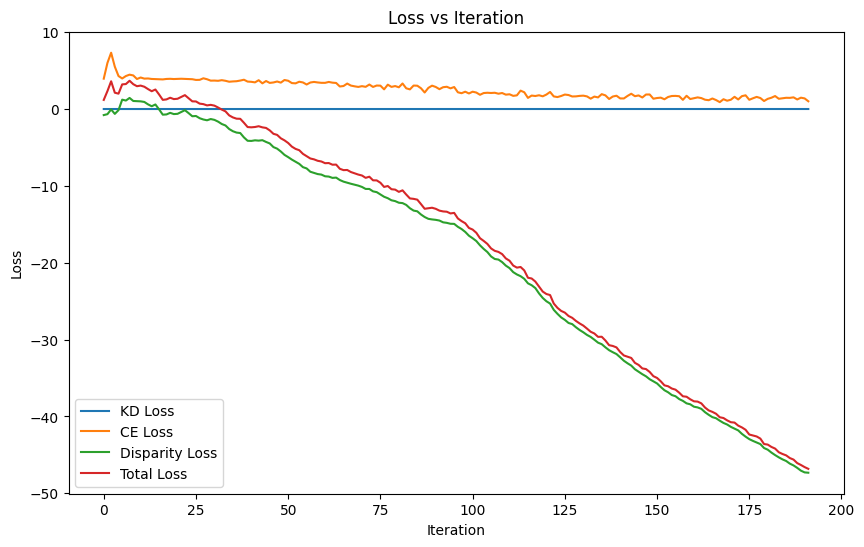

In [20]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Update the total number of epochs to include fine-tuning epochs
total_epochs = num_epochs + fine_tune_epochs

# Lists to store loss values
kd_loss_values = []
ce_loss_values = []
disparity_loss_values = []
total_loss_values = []

# Training loop
for epoch in range(total_epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{total_epochs}')
    # Change learning rate for fine-tuning phase
    if epoch == num_epochs:
        for param_group in optimizer_student.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        for param_group in optimizer_teacher.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        print(f'Starting fine-tuning with learning rate: {fine_tune_learning_rate}')

    student_model.train()
    teacher_model.train()
    for images, labels, annotations in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)

        # Calculate additional metrics including recall
        y_true = labels.cpu().numpy()
        y_pred_student = torch.argmax(student_outputs, dim=1).cpu().numpy()
        y_pred_teacher = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        
        # Calculate additional metrics including recall
        recall_student = recall_score(y_true, y_pred_student, average='weighted', zero_division=0)
        recall_teacher = recall_score(y_true, y_pred_teacher, average='weighted', zero_division=0)

        # Update recall values
        for attr in attributes:
            for concept in concepts:
                # Check if the sample belongs to the specified attribute and concept
                attr_indices = np.where(annotations[:, attr_idx[attr]].cpu().numpy() == 1)[0]  # Get indices where attribute is 1
                concept_indices = np.where(labels.cpu().numpy() == class_to_idx[concept])[0]  # Get indices where concept matches
                common_indices = np.intersect1d(attr_indices, concept_indices)  # Common indices
                if common_indices.size > 0:
                    teacher_recall_values[attr][concept].append(recall_teacher)
                    student_recall_values[attr][concept].append(recall_student)

        # Calculate the Knowledge Distillation loss and Cross Entropy loss
        kd_loss = criterion_student(
            F.log_softmax(student_outputs / temperature, dim=1),  # Apply temperature scaling
            F.softmax(teacher_outputs / temperature, dim=1)  # Apply temperature scaling
        )
        ce_loss = criterion_teacher(student_outputs, labels)
        
        # Append the loss values for plotting
        kd_loss_values.append(kd_loss.item())
        ce_loss_values.append(ce_loss.item())
    
        # Calculate the disparity for each attribute and concept
        disparity_loss_sum = 0  # Initialize a variable to sum the disparity losses
        for attr in attributes:
            for concept in concepts:
                # Check if the recall values lists are not empty before computing the mean
                if teacher_recall_values[attr][concept] and student_recall_values[attr][concept]:
                    teacher_recall = np.mean(teacher_recall_values[attr][concept])
                    student_recall = np.mean(student_recall_values[attr][concept])
                    disparity = teacher_recall - student_recall
                    disparity_tensor = torch.tensor(disparity, dtype=torch.float32).to(device)  # Convert disparity to a PyTorch tensor
                    disparity_loss_sum += disparity_weight * disparity_tensor  # Sum the disparity losses

        if torch.isnan(disparity_loss_sum):
            disparity_loss_sum = torch.tensor(0.0, dtype=torch.float32).to(device)
                
        disparity_loss_values.append(disparity_loss_sum.item())
        # Combine the losses
        total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + disparity_loss_sum

        # Append the total loss value for plotting
        total_loss_values.append(total_loss.item())

        # Perform the backward pass
        total_loss.backward()

        # Optimize the models
        optimizer_student.step()
        optimizer_teacher.step()

        # Zero the gradients after updating weights
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        print(f'KD Loss: {kd_loss.item()}')
        print(f'CE Loss: {ce_loss.item()}')
        print(f'Disparity Loss: {disparity_loss_sum.item()}')
        print(f'Total Loss: {total_loss.item()}')
        print(f'teacher_recall: {teacher_recall}, student_recall: {student_recall}')

        # print(f'Labels: {labels.cpu().numpy()}')
        # print(f'Student Predictions: {torch.argmax(student_outputs, dim=1).cpu().numpy()}')
        # print(f'Teacher Predictions: {torch.argmax(teacher_outputs, dim=1).cpu().numpy()}')
        # print(f'attr_indices: {attr_indices}')
        # print(f'concept_indices: {concept_indices}')
        # print(f'common_indices: {common_indices}')
        # print(f'Student Outputs: {student_outputs}')
        # print(f'Teacher Outputs: {teacher_outputs}')
        # print(f'annotations: {annotations}')
        # print(f'attr: {attr}, concept: {concept}')
        # print(f'attr_idx: {attr_idx}, class_to_idx: {class_to_idx}')
        # print(f'Size of common_indices: {common_indices.size}')
        # print(f'Manual Student Recall: {recall_score(y_true, y_pred_student, average="weighted", zero_division=0)}')
        # print(f'Manual Teacher Recall: {recall_score(y_true, y_pred_teacher, average="weighted", zero_division=0)}')

# Disable anomaly detection when done
torch.autograd.set_detect_anomaly(False)

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(kd_loss_values, label='KD Loss')
plt.plot(ce_loss_values, label='CE Loss')
plt.plot(disparity_loss_values, label='Disparity Loss')
plt.plot(total_loss_values, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iteration')
plt.show()


# Evaluate

In [21]:
def calculate_disparity(teacher_recall_values, student_recall_values):
    disparity_values = {}
    for attr in attributes:  # Ensure 'attributes' is defined and correctly formatted
        disparity_values[attr] = {}
        for concept in concepts:  # Ensure 'concepts' is defined and correctly formatted
            teacher_values = teacher_recall_values.get(attr, {}).get(concept, [])
            student_values = student_recall_values.get(attr, {}).get(concept, [])
            if teacher_values and student_values:  # Check non-empty lists
                disparity_values[attr][concept] = np.mean(
                    [teacher_val - student_val for teacher_val, student_val in zip(teacher_values, student_values)]
                )
            else:
                print(f"Missing values for attr: {attr}, concept: {concept}")  # Debugging print statement
    return disparity_values

In [22]:
# Validation
student_model.eval()
teacher_model.eval()
val_loss_student = 0.0
val_predictions_student = []
val_targets_student = []

val_loss_teacher = 0.0
val_predictions_teacher = []
val_targets_teacher = []

start_time = time.time()

with torch.no_grad():
    for images, labels, annotations in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        student_outputs = student_model(images)
        teacher_outputs = teacher_model(images)

        # Calculate cross-entropy loss for validation
        student_loss = criterion_teacher(student_outputs, labels)
        teacher_loss = criterion_teacher(teacher_outputs, labels)

        val_loss_student += student_loss.item()
        val_loss_teacher += teacher_loss.item()

        # Store predictions and ground truth labels for metrics
        val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
        val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

        val_targets_student.extend(labels.cpu().numpy())
        val_targets_teacher.extend(labels.cpu().numpy())

end_time = time.time()  # End time measurement
inference_time_student = (end_time - start_time) / len(val_loader)
inference_time_teacher = (end_time - start_time) / len(val_loader)

val_disparity_values = calculate_disparity(teacher_recall_values, student_recall_values)

# Calculate the average disparity
avg_disparity = np.mean(
    [value for attr_dict in val_disparity_values.values()
     for concept_dict in attr_dict.values()
     for value in (concept_dict.values() if isinstance(concept_dict, dict) else [concept_dict])])


# Calculate validation accuracy and recall
val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
val_recall_student = recall_score(val_targets_student, val_predictions_student, average='weighted')
val_recall_teacher = recall_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_precision_student = precision_score(val_targets_student, val_predictions_student, average='weighted')
val_precision_teacher = precision_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_f1_student = f1_score(val_targets_student, val_predictions_student, average='weighted')
val_f1_teacher = f1_score(val_targets_teacher, val_predictions_teacher, average='weighted')

# Get model size (number of parameters)
model_size_student = sum(p.numel() for p in student_model.parameters())
model_size_teacher = sum(p.numel() for p in teacher_model.parameters())

val_metrics_teacher = calculate_metrics(val_targets_teacher, val_predictions_teacher)
val_metrics_student = calculate_metrics(val_targets_student, val_predictions_student)
  
# Gather metrics in dictionaries for easier plotting
teacher_metrics = {
    'Accuracy': val_metrics_teacher[0],
    'Precision': val_metrics_teacher[1],
    'Recall': val_metrics_teacher[2],
    'F1 Score': val_metrics_teacher[3],
    'Disparity': avg_disparity,
    'Model Size': model_size_teacher,
    'Inference Time': inference_time_teacher
}

student_metrics = {
    'Accuracy': val_metrics_student[0],
    'Precision': val_metrics_student[1],
    'Recall': val_metrics_student[2],
    'F1 Score': val_metrics_student[3],
    'Disparity': avg_disparity,
    'Model Size': model_size_student,
    'Inference Time': inference_time_student
}

# Define labels for plotting
size_labels = ['Model Size']
time_labels = ['Inference Time']
other_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Disparity']  # Define labels for other metrics

# Extract values for each type of metric
size_teacher_values = [teacher_metrics['Model Size']]
size_student_values = [student_metrics['Model Size']]

time_teacher_values = [teacher_metrics['Inference Time']]
time_student_values = [student_metrics['Inference Time']]

other_teacher_values = [teacher_metrics[key] for key in other_labels]
other_student_values = [student_metrics[key] for key in other_labels]

# Print validation results for this epoch
print(f'Epoch [{epoch+1}/{num_epochs}]'
      f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
      f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
      f' Teacher Recall: {val_recall_teacher:.4f}'
      f' Student Loss: {val_loss_student / len(val_loader):.4f}'
      f' Student Accuracy: {val_accuracy_student:.4f}'
      f' Student Recall: {val_recall_student:.4f}')

# Print disparity for validation
for attr in attributes:
    for concept in concepts:
        # Handle potential missing values with a default of NaN or another value of your choice
        print(f'Validation Disparity for {attr} and {concept}: {val_disparity_values.get(attr, {}).get(concept, np.nan):.4f}')


Missing values for attr: gender_presentation_masc, concept: cheerleader
Missing values for attr: gender_presentation_masc, concept: bartender
Missing values for attr: gender_presentation_fem, concept: astronaut
Missing values for attr: gender_presentation_fem, concept: fireman
Missing values for attr: gender_presentation_fem, concept: referee
Missing values for attr: gender_presentation_fem, concept: flutist
Missing values for attr: gender_presentation_fem, concept: carpenter
Missing values for attr: gender_presentation_fem, concept: ballplayer
Missing values for attr: gender_presentation_fem, concept: electrician
Missing values for attr: gender_presentation_fem, concept: trumpeter
Missing values for attr: gender_presentation_fem, concept: bartender
Missing values for attr: gender_presentation_non_binary, concept: gymnast
Missing values for attr: gender_presentation_non_binary, concept: boatman
Missing values for attr: gender_presentation_non_binary, concept: lifeguard
Missing values f

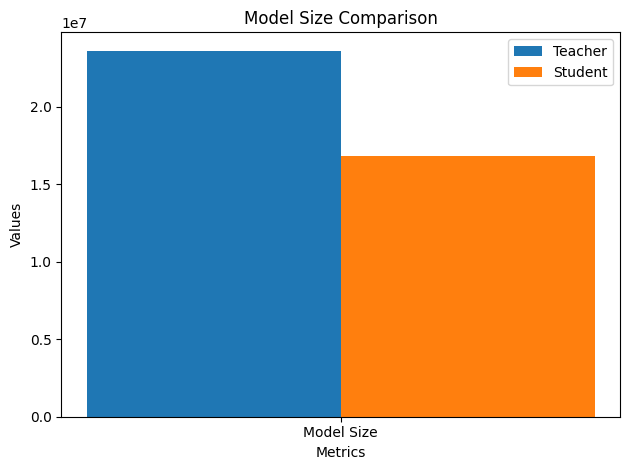

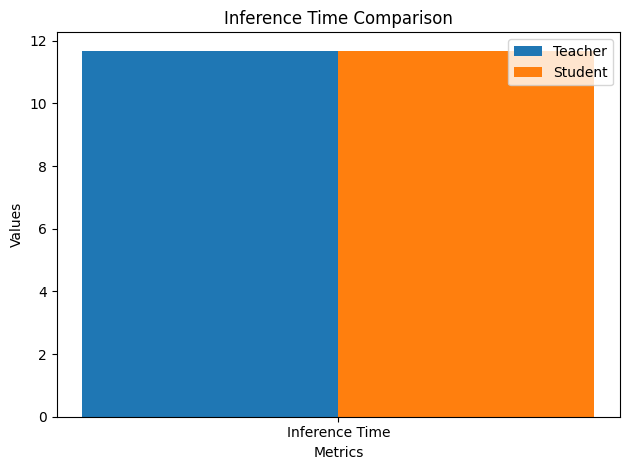

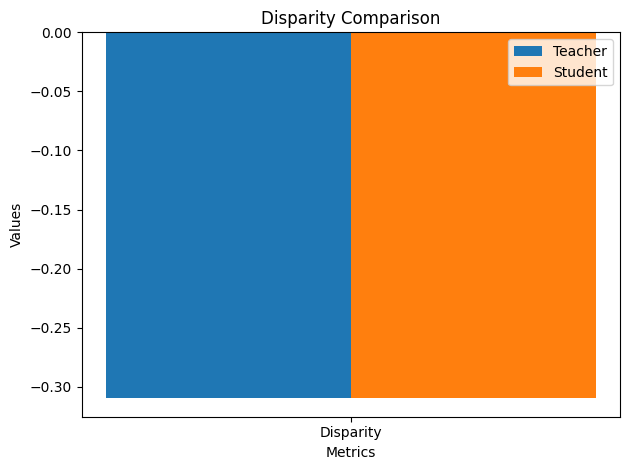

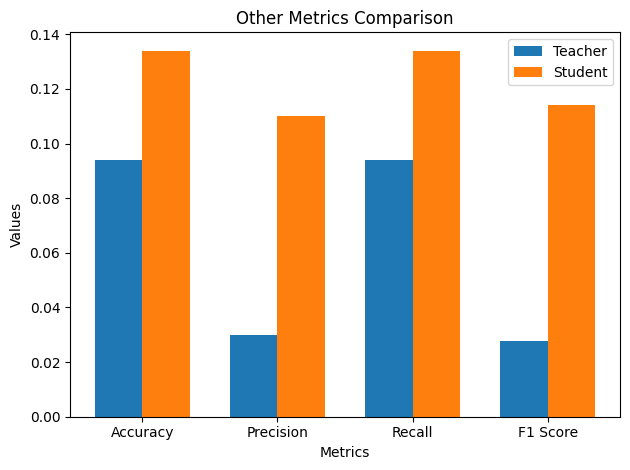

In [23]:
def create_plot(labels, teacher_values, student_values, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Function to create a bar plot specifically for disparity
def plot_disparity(title):
    labels = ['Disparity']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [teacher_metrics['Disparity']], width, label='Teacher')
    rects2 = ax.bar(x + width/2, [student_metrics['Disparity']], width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Create plots
create_plot(size_labels, size_teacher_values, size_student_values, 'Model Size Comparison')
create_plot(time_labels, time_teacher_values, time_student_values, 'Inference Time Comparison')
plot_disparity('Disparity Comparison')
create_plot(other_labels[:-1], other_teacher_values[:-1], other_student_values[:-1], 'Other Metrics Comparison')  

In [24]:
torch.save(student_model.state_dict(), 'student_model.pth')
torch.save(teacher_model.state_dict(), 'teacher_model.pth')